In [1]:
import os,sys,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from itertools import product
#import pickle5 # Need pickle5 for DataFrame pickles
from scipy.stats import linregress,sem
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mue
import seaborn as sns
from natsort import natsorted as ns
from natsort import *
import matplotlib as mpl
import multiprocessing as mp
cpus = mp.cpu_count()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import log


In [2]:
A8 = pd.read_pickle('../../data/EE/A8_RBFE.pkl')
A13 = pd.read_pickle('../../data/EE/A13_RBFE.pkl').fillna(0)
A18 = pd.read_pickle('../../data/EE/A18_RBFE.pkl')
A8_var = pd.read_pickle('../../data/EE/A8_variance.pkl')
A13_var = pd.read_pickle('../../data/EE/A13_variance.pkl').fillna(0)
A18_var = pd.read_pickle('../../data/EE/A18_variance.pkl')
on = False
if on:
    for col in A8.columns:
        A8[col] = np.mean(A8[col].values+np.random.randn(100000,len(A8[col]))*A8_var[col].values,axis=0)
    for col in A18.columns:
        A18[col] = np.mean(A18[col].values+np.random.randn(100000,len(A18[col]))*A18_var[col].values,axis=0)
    for col in A13.columns:
        A13[col] = np.mean(A13[col].values+np.random.randn(100000,len(A13[col]))*A13_var[col].values,axis=0)

A8_old = pd.read_pickle('../../data/old_EE/A8_RBFE.pkl').fillna(0)
A13_old = pd.read_pickle('../../data/old_EE/A13_RBFE.pkl').fillna(0)
A18_old = pd.read_pickle('../../data/old_EE/A18_RBFE.pkl').fillna(0)
old_A8_var = pd.read_pickle('../../data/old_EE/A8_variance.pkl').fillna(0)
old_A13_var = pd.read_pickle('../../data/old_EE/A13_variance.pkl').fillna(0)
old_A18_var = pd.read_pickle('../../data/old_EE/A18_variance.pkl').fillna(0)

#A8_exp = pd.read_csv('A8_initial_Log10Kd_estimates_20230913.csv')
A8_exp = pd.read_pickle('../../data/Experiment/A8_exp_dg.pkl').reindex(A8.index).fillna(0)
A8_exp_unc = pd.read_pickle('../../data/Experiment/A8_exp_unc.pkl').reindex(A8.index).fillna(0)
A8_seq = open('../../data/sequences/A8_sequence.afasta').readlines()[0].replace('\n','')
#A8_exp=transform_exp(A8_exp,A8_seq)
A8_seq =[f'{A8_seq[i]}{270+i}' for i in range(len(A8_seq))]


#A18_exp = pd.read_csv('A18_initial_Log10Kd_estimates_20230913.csv')
A18_exp = pd.read_pickle('../../data/Experiment/A18_exp_dg.pkl').reindex(A18.index).fillna(0)
A18_exp_unc = pd.read_pickle('../../data/Experiment/A18_exp_unc.pkl').reindex(A18.index).fillna(0)
A18_seq = open('../../data/sequences/A18_sequence.afasta').readlines()[0].replace('\n','')
#A18_exp=transform_exp(A18_exp,A18_seq)
A18_seq=[f'{A18_seq[i]}{270+i}' for i in range(len(A18_seq))]


#A13_exp = pd.read_csv('A13_initial_Log10Kd_estimates_20230913.csv')
A13_exp = pd.read_pickle('../../data/Experiment/A13_exp_dg.pkl').reindex(A13.index).fillna(0)
A13_exp_unc = pd.read_pickle('../../data/Experiment/A13_exp_unc.pkl').reindex(A13.index).fillna(0)
A13_seq = open('../../data/sequences/A13_sequence.afasta').readlines()[0].replace('\n','')
#A13_exp=transform_exp(A13_exp,A13_seq)
A13_seq =[f'{A13_seq[i]}{270+i}' for i in range(len(A13_seq))]

# Fix Rosetta A8 Df
A8_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A8_rosetta.csv')
A8_ros_pub = A8_ros_pub.rename(columns={A8_ros_pub.columns[0]:''}) 
A8_ros_pub.set_index(A8_ros_pub.columns[0],inplace=True)

# Fix Rosetta A13 Df
A13_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A13_rosetta.csv')
A13_ros_pub = A13_ros_pub.rename(columns={A13_ros_pub.columns[0]:''}) 
A13_ros_pub.set_index(A13_ros_pub.columns[0],inplace=True)

# Fix Rosetta A18 Df
A18_ros_pub = pd.read_csv('../../data/published_rosetta/norm_final_A18_rosetta.csv')
A18_ros_pub = A18_ros_pub.rename(columns={A18_ros_pub.columns[0]:''}) 
A18_ros_pub.set_index(A18_ros_pub.columns[0],inplace=True)


A8_ros_pub = A8_ros_pub * -1
A13_ros_pub = A13_ros_pub * -1
A18_ros_pub = A18_ros_pub * -1

A8_curr_ros = pd.read_csv('../../data/current_rosetta/A8_current_rosetta.csv')
A13_curr_ros = pd.read_csv('../../data/current_rosetta/A13_current_rosetta.csv')
A18_curr_ros = pd.read_csv('../../data/current_rosetta/A18_current_rosetta.csv')


def make_df(output,temp):
    output = output[output['state']=='ddg']
    index = list(temp.index)
    columns = temp.columns
    array = np.zeros(shape=(len(index),len(columns)))
    temp = pd.DataFrame(array,index=index,columns=columns)
    for index,row in output.iterrows():
        _col = row['position_label']
        _mut = row['mutation'][-1]
        _val = row['total_score']
        temp[_col][_mut]+=_val
    return temp

A8_curr_ros = make_df(A8_curr_ros,A8_ros_pub.copy())
A13_curr_ros = make_df(A13_curr_ros,A13_ros_pub.copy())
A18_curr_ros = make_df(A18_curr_ros,A18_ros_pub.copy())

# Affinity Maturation Single Mutations Table

In [36]:
mutations = {'A8':['R272G','V300K','Q303E','E305R','T307V','Total'],            
             'A13':['I273Q','V275F','P278L','E294T','D298M','D299V','Total'],                                                                                                                              
             'A18':['D272E','T274R','D277N','A285L','D294A','N300I','Total']}

A8_AM = {mut:{'Exp.':0,'EE':0,'Flex ddG':0} for mut in mutations['A8']}
A13_AM = {mut:{'Exp.':0,'EE':0,'Flex ddG':0} for mut in mutations['A13']}
A18_AM = {mut:{'Exp.':0,'EE':0,'Flex ddG':0} for mut in mutations['A18']}

A8_AM_var = {mut:{'Exp.':0,'EE':0,'Flex ddG':0} for mut in mutations['A8']}
A13_AM_var = {mut:{'Exp.':0,'EE':0,'Flex ddG':0} for mut in mutations['A13']}
A18_AM_var = {mut:{'Exp.':0,'EE':0,'Flex ddG':0} for mut in mutations['A18']}

In [37]:
EE_total = 0
Exp_total = 0
Flex_ddG_total = 0
Flex_ddG_unc = 0.96*(1/1.84)

EE_total_unc = 0
Exp_total_unc = 0
Flex_ddG_total_unc = 0
for mut in mutations['A8']:
    if mut != 'Total':
        col = mut[:-1]
        m = mut[-1]
        EE = float(A8[col][m])
        Exp = float(A8_exp[col][m])
        Flex_ddG = float(A8_curr_ros[col][m])
        #Chev_17 = float(A8_ros_pub[col][m])
        EE_unc = float(A8_var[col][m])
        Exp_unc = float(A8_exp_unc[col][m])
        
        A8_AM[mut]['Exp.']+=Exp
        A8_AM[mut]['EE']+=EE
        A8_AM[mut]['Flex ddG']+=Flex_ddG
        
        A8_AM_var[mut]['Exp.']+=Exp_unc
        A8_AM_var[mut]['EE']+=EE_unc
        A8_AM_var[mut]['Flex ddG']+=Flex_ddG_unc
        
        #A8_AM[mut]['Chev.17']+=Chev_17
        EE_total += EE
        Exp_total += Exp
        Flex_ddG_total += Flex_ddG
        #Chev_17_total += Chev_17
        EE_total_unc += EE_unc**2
        Exp_total_unc += Exp_unc**2
        Flex_ddG_total_unc += Flex_ddG_unc**2

A8_AM['Total']['EE'] = EE_total
A8_AM['Total']['Exp.'] = Exp_total
A8_AM['Total']['Flex ddG'] = Flex_ddG_total

A8_AM_var['Total']['EE'] = np.sqrt(EE_total_unc)
A8_AM_var['Total']['Exp.'] =  np.sqrt(Exp_total_unc)
A8_AM_var['Total']['Flex ddG'] =  np.sqrt(Flex_ddG_total_unc)
#A8_AM['Total']['Chev.17'] = Chev_17_total

A8_AM = pd.DataFrame(A8_AM).round(2)
A8_AM_var = pd.DataFrame(A8_AM_var).round(2)

In [38]:
EE_total = 0
Exp_total = 0
Flex_ddG_total = 0
Flex_ddG_unc = 0.96*(1/1.84)

EE_total_unc = 0
Exp_total_unc = 0
Flex_ddG_total_unc = 0
for mut in mutations['A13']:
    if mut != 'Total':
        col = mut[:-1]
        m = mut[-1]
        EE = float(A13[col][m])
        Exp = float(A13_exp[col][m])
        Flex_ddG = float(A13_curr_ros[col][m])
        #Chev_17 = float(A13_ros_pub[col][m])
        EE_unc = float(A13_var[col][m])
        Exp_unc = float(A13_exp_unc[col][m])
        
        A13_AM[mut]['Exp.']+=Exp
        A13_AM[mut]['EE']+=EE
        A13_AM[mut]['Flex ddG']+=Flex_ddG
        
        A13_AM_var[mut]['Exp.']+=Exp_unc
        A13_AM_var[mut]['EE']+=EE_unc
        A13_AM_var[mut]['Flex ddG']+=Flex_ddG_unc
        
        #A13_AM[mut]['Chev.17']+=Chev_17
        EE_total += EE
        Exp_total += Exp
        Flex_ddG_total += Flex_ddG
        #Chev_17_total += Chev_17
        EE_total_unc += EE_unc**2
        Exp_total_unc += Exp_unc**2
        Flex_ddG_total_unc += Flex_ddG_unc**2

A13_AM['Total']['EE'] = EE_total
A13_AM['Total']['Exp.'] = Exp_total
A13_AM['Total']['Flex ddG'] = Flex_ddG_total

A13_AM_var['Total']['EE'] = np.sqrt(EE_total_unc)
A13_AM_var['Total']['Exp.'] =  np.sqrt(Exp_total_unc)
A13_AM_var['Total']['Flex ddG'] =  np.sqrt(Flex_ddG_total_unc)
#A13_AM['Total']['Chev.17'] = Chev_17_total

A13_AM = pd.DataFrame(A13_AM).round(2)
A13_AM_var = pd.DataFrame(A13_AM_var).round(2)

In [39]:
EE_total = 0
Exp_total = 0
Flex_ddG_total = 0
Flex_ddG_unc = 0.96*(1/1.84)

EE_total_unc = 0
Exp_total_unc = 0
Flex_ddG_total_unc = 0
for mut in mutations['A18']:
    if mut != 'Total':
        col = mut[:-1]
        m = mut[-1]
        EE = float(A18[col][m])
        Exp = float(A18_exp[col][m])
        Flex_ddG = float(A18_curr_ros[col][m])
        #Chev_17 = float(A18_ros_pub[col][m])
        EE_unc = float(A18_var[col][m])
        Exp_unc = float(A18_exp_unc[col][m])
        
        A18_AM[mut]['Exp.']+=Exp
        A18_AM[mut]['EE']+=EE
        A18_AM[mut]['Flex ddG']+=Flex_ddG
        
        A18_AM_var[mut]['Exp.']+=Exp_unc
        A18_AM_var[mut]['EE']+=EE_unc
        A18_AM_var[mut]['Flex ddG']+=Flex_ddG_unc
        
        #A18_AM[mut]['Chev.17']+=Chev_17
        EE_total += EE
        Exp_total += Exp
        Flex_ddG_total += Flex_ddG
        #Chev_17_total += Chev_17
        EE_total_unc += EE_unc**2
        Exp_total_unc += Exp_unc**2
        Flex_ddG_total_unc += Flex_ddG_unc**2

A18_AM['Total']['EE'] = EE_total
A18_AM['Total']['Exp.'] = Exp_total
A18_AM['Total']['Flex ddG'] = Flex_ddG_total

A18_AM_var['Total']['EE'] = np.sqrt(EE_total_unc)
A18_AM_var['Total']['Exp.'] =  np.sqrt(Exp_total_unc)
A18_AM_var['Total']['Flex ddG'] =  np.sqrt(Flex_ddG_total_unc)
#A18_AM['Total']['Chev.17'] = Chev_17_total

A18_AM = pd.DataFrame(A18_AM).round(2)
A18_AM_var = pd.DataFrame(A18_AM_var).round(2)

In [40]:
A8_annot = A8_AM.astype(str)+"$\pm$"+A8_AM_var.astype(str)
A8_annot

,R272G,V300K,Q303E,E305R,T307V,Total
Exp.,0.96$\pm$0.06,0.93$\pm$0.05,0.42$\pm$0.03,0.46$\pm$0.03,-1.03$\pm$0.03,1.74$\pm$0.09
EE,-2.88$\pm$5.93,0.54$\pm$2.04,0.16$\pm$6.02,3.32$\pm$6.79,-0.68$\pm$1.26,0.47$\pm$11.11
Flex ddG,0.11$\pm$0.52,0.03$\pm$0.52,-0.04$\pm$0.52,-0.01$\pm$0.52,0.01$\pm$0.52,0.11$\pm$1.17


In [54]:
A18_annot = A18_AM.astype(str)+"$\pm$"+A18_AM_var.astype(str)
A13_annot = A13_AM.astype(str)+"$\pm$"+A13_AM_var.astype(str)


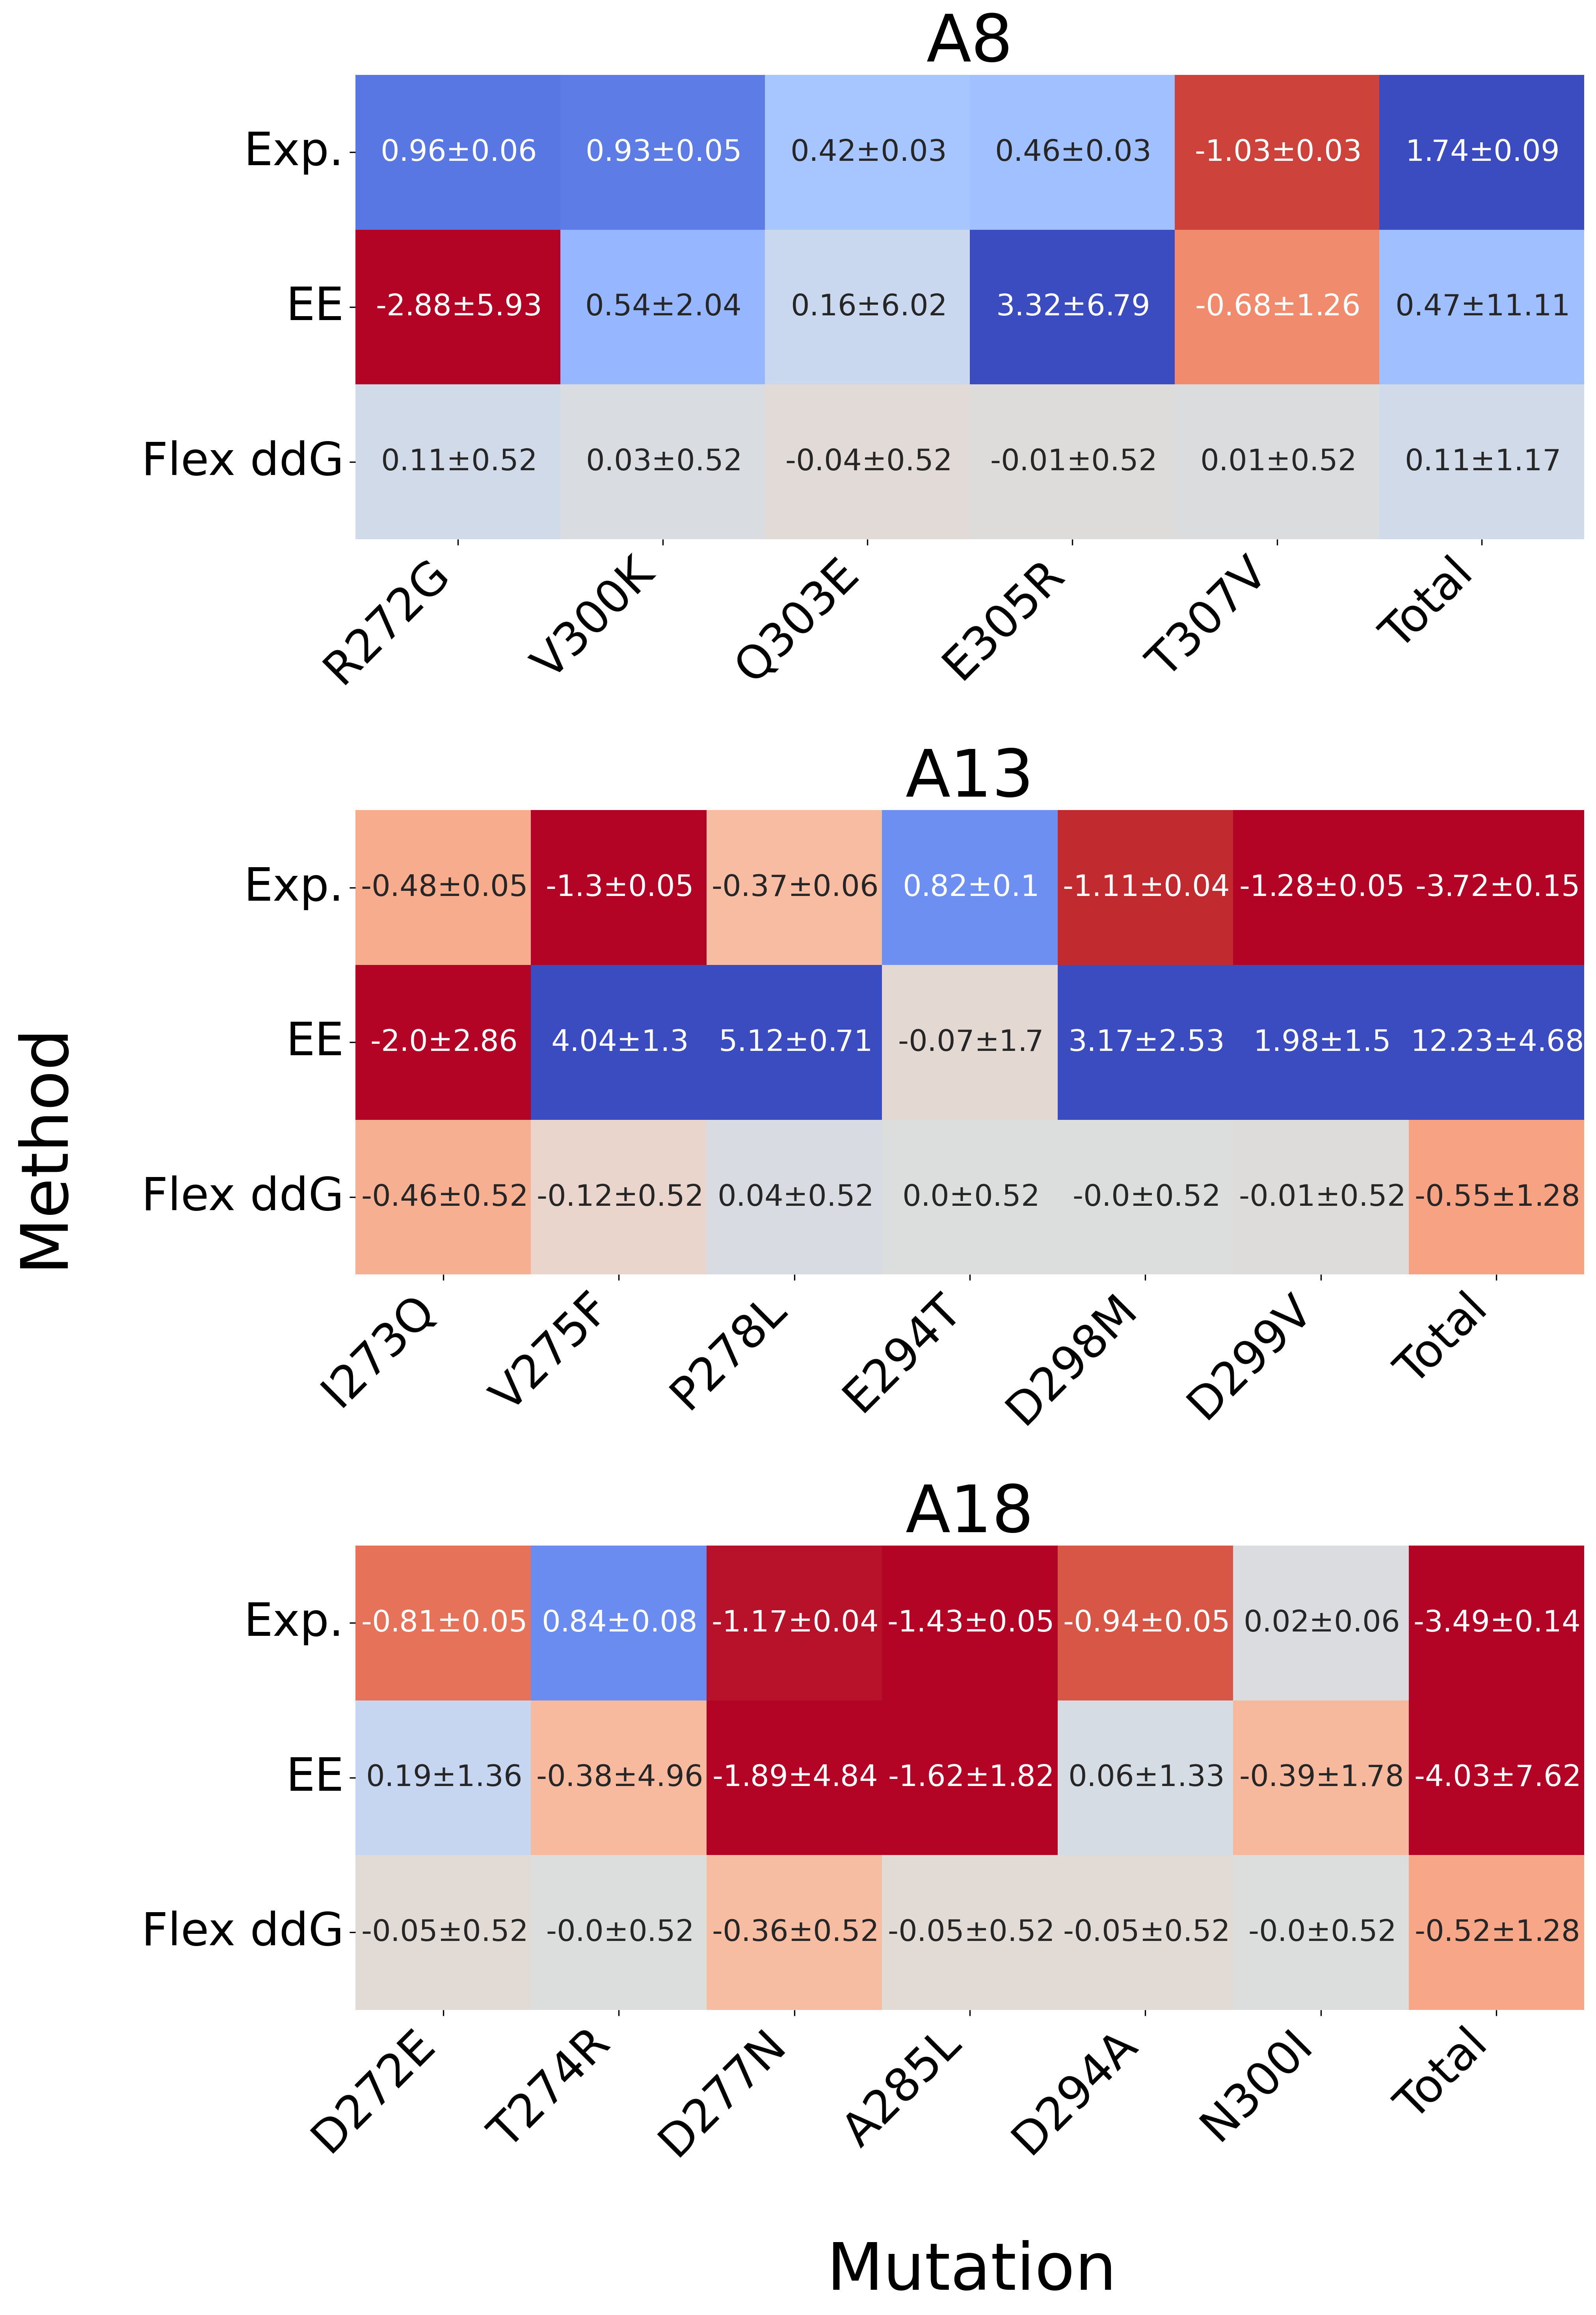

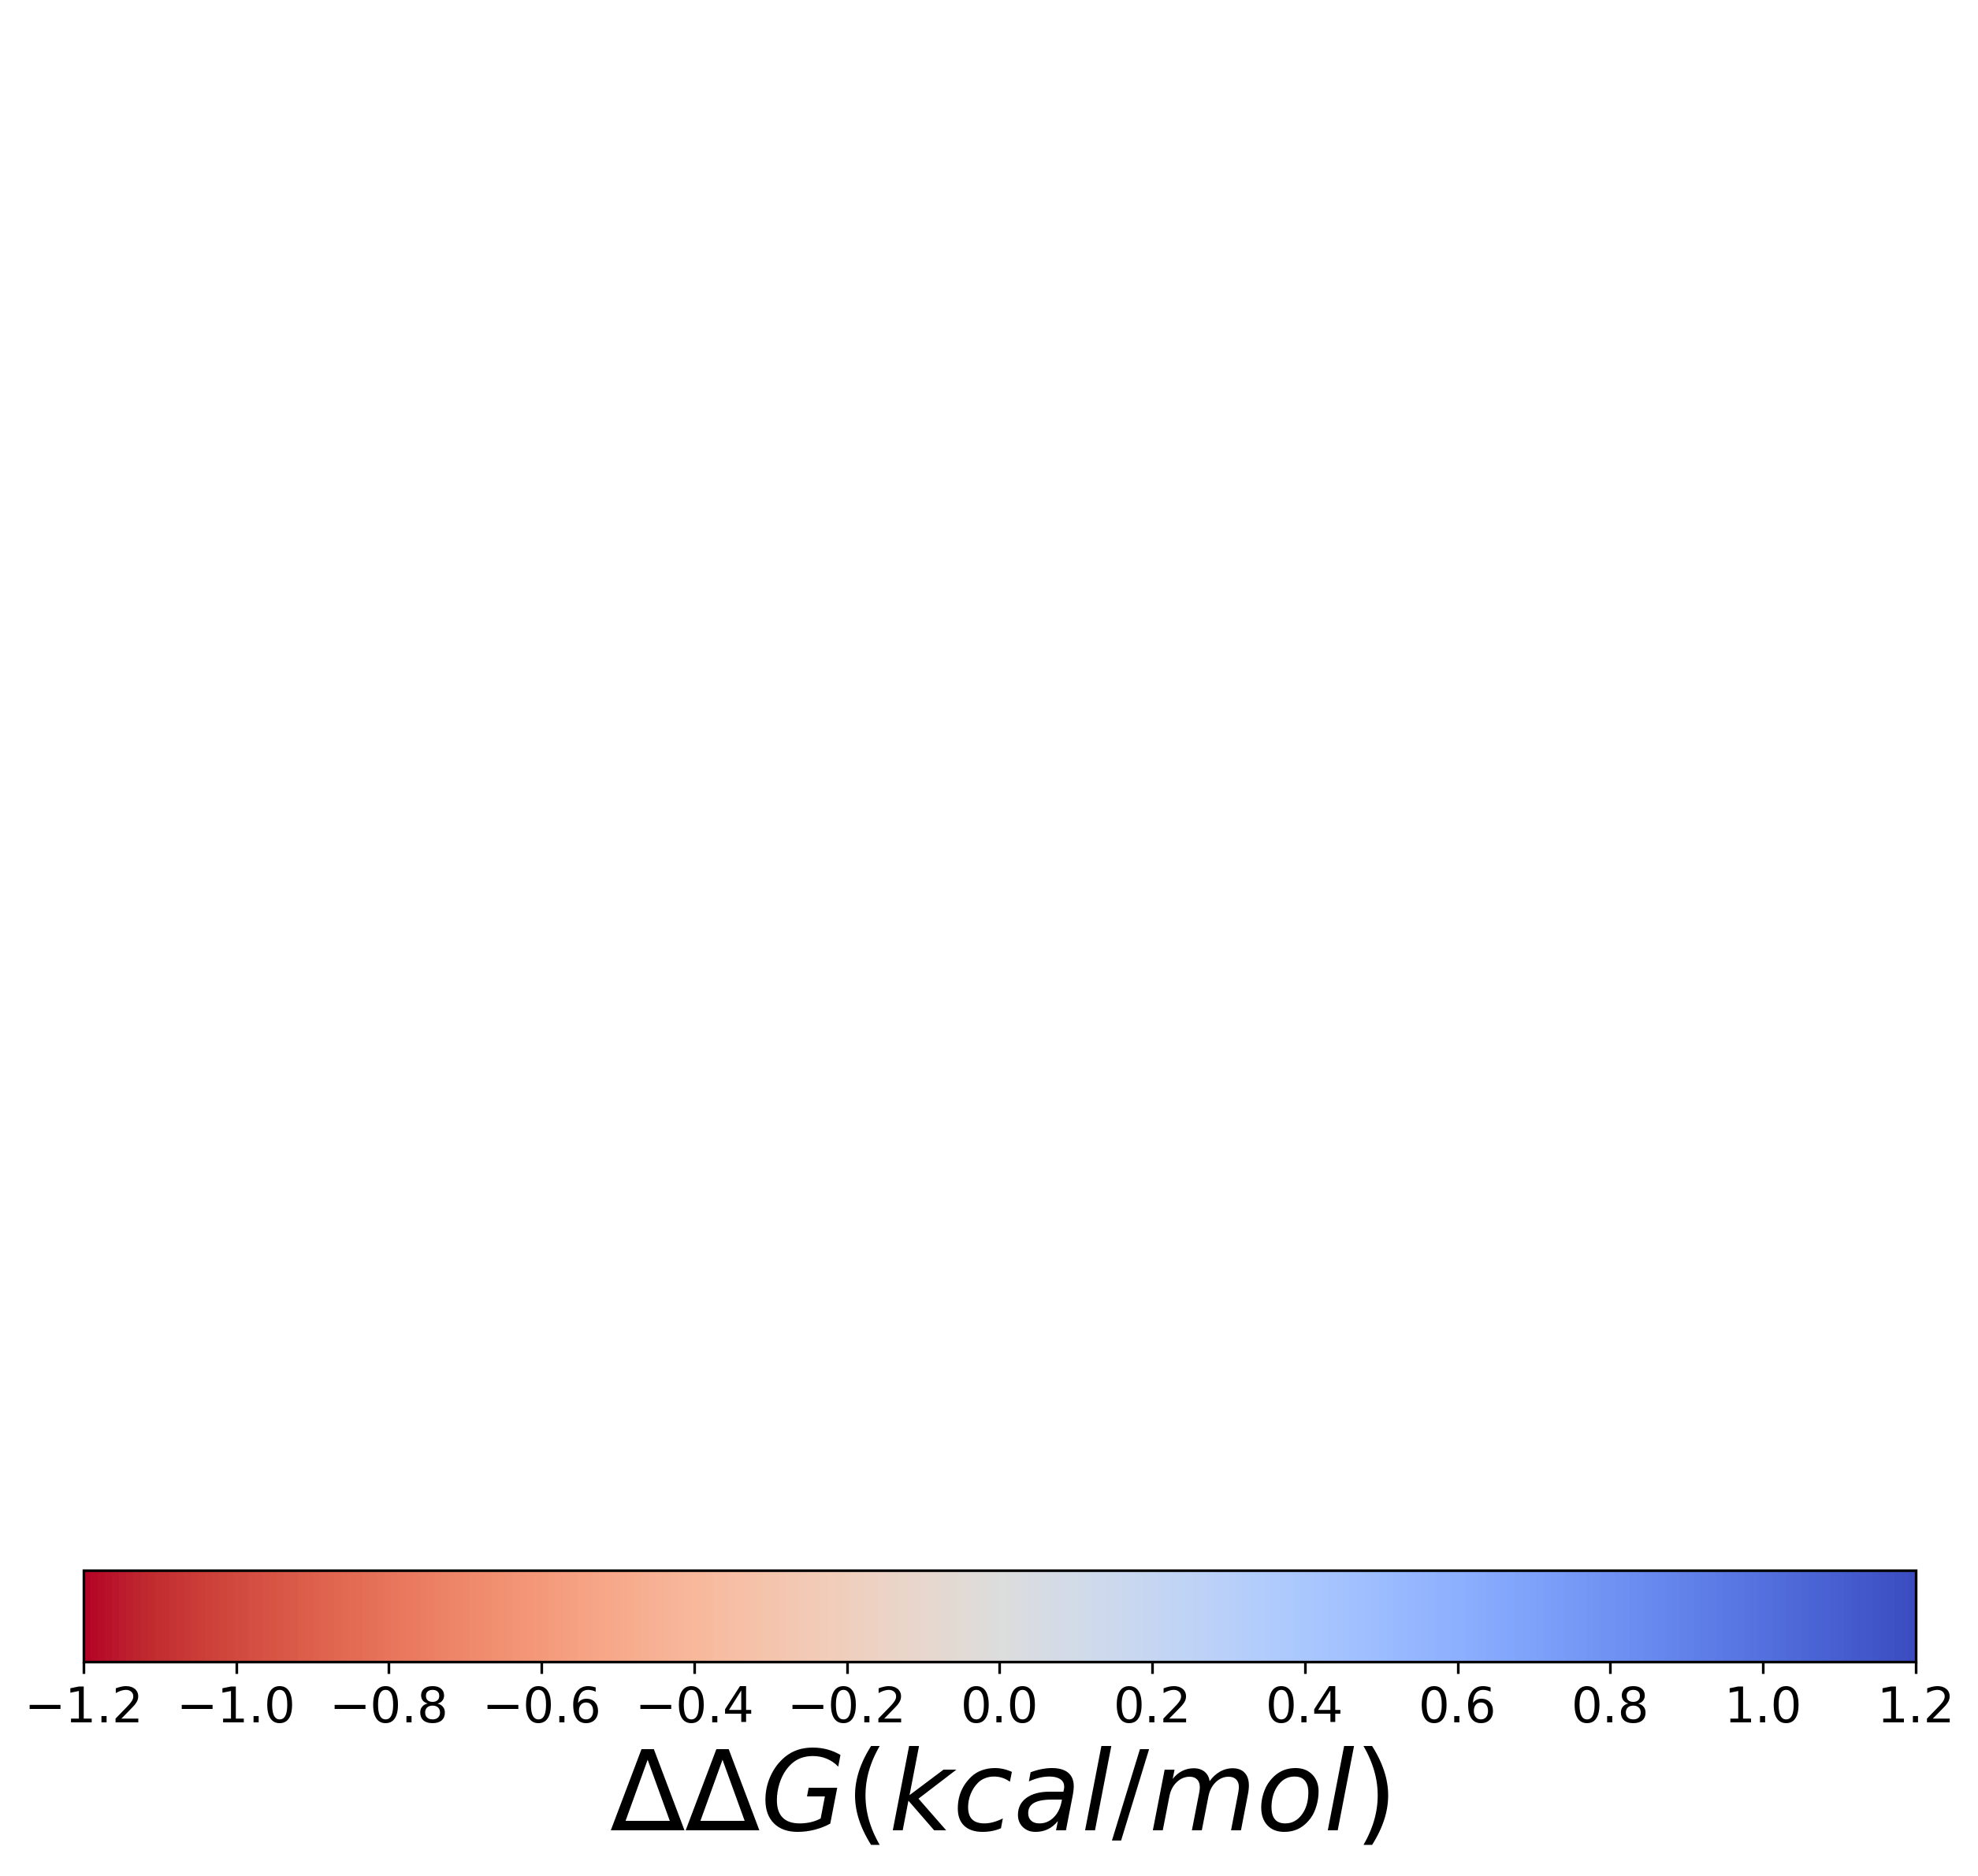

In [87]:
names = ['A8','A13','A18']
fig,axes = plt.subplots(3,1,figsize=(14,20),dpi=300)
plt.rcParams.update({'font.size': 28})
ax1,ax2,ax3 = axes.flat
im=sns.heatmap(A8_AM,cmap='coolwarm_r',vmin=-1.2,vmax=1.2,annot=A8_annot,
            annot_kws={'fontsize': 18},ax=ax1,cbar=False,fmt='')
sns.heatmap(A13_AM,cmap='coolwarm_r',vmin=-1.2,vmax=1.2,annot=A13_annot,
            annot_kws={'fontsize': 18},ax=ax2,cbar=False  ,fmt='')
sns.heatmap(A18_AM,cmap='coolwarm_r',vmin=-1.2,vmax=1.2,annot=A18_annot,
            annot_kws={'fontsize': 18},ax=ax3,cbar=False  ,fmt='')
for i,ax in enumerate(axes.flat):
    ax.set_title(names[i],fontsize=40)
    ax.set_xticklabels(list(ax.get_xticklabels()),rotation=45,ha='right')
    ax.set_yticklabels([case for case in A8_AM.index],rotation=0)
fig.supylabel('Method',fontsize=40)
fig.supxlabel('Mutation',fontsize=40,x=0.6)


fig.tight_layout()
plt.show()
fig.savefig('Affinity_maturation.png',dpi=300,transparent=True)
mappable = im.get_children()[0]
plt.close()
fig,ax= plt.subplots(figsize=(10,10),dpi=300)
ax.set_axis_off()       
# Display the color bar with a gradient legend      
cbar = plt.colorbar(mappable, ax=ax ,orientation = 'horizontal')
cbar.set_ticks(np.arange(-1.2,1.22,0.2))
cbar.set_label('$\Delta \Delta G (kcal/mol)$',fontsize='large')     
cbar.ax.tick_params(labelsize=15)          
plt.savefig(f'AM_colorbar.png',dpi=300,bbox_inches='tight', pad_inches=0, transparent=True)   
